In [33]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [34]:
data_seed, params_seed = 42, 120

(42, 120)

In [35]:
import ReactiveMP.messageout

In [36]:
include("../helpers/data.jl")

generate_data

In [37]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [38]:
# order = 1
Y = zeros(3); Y[1] = 1.0;
U = zeros(3); U[2] = 1.0;
H = zeros(3); H[3] = 1.0;

In [39]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(0.0, 1e12))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    Ys = [Y*y_prev[i] for i in 1:n]
    Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Univariate, 1, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ NormalMeanPrecision(0.0, 1e12)
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dimension*3))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [40]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(0.0, 0.1), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior,
                                                                       observations_prev, controls,
                                                                       options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [41]:
# specify flow model
dimension = 3
model_flow = FlowModel(dimension,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [42]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>1, :order_u=>1, :order_e=>1),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [43]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[1:end];

In [44]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

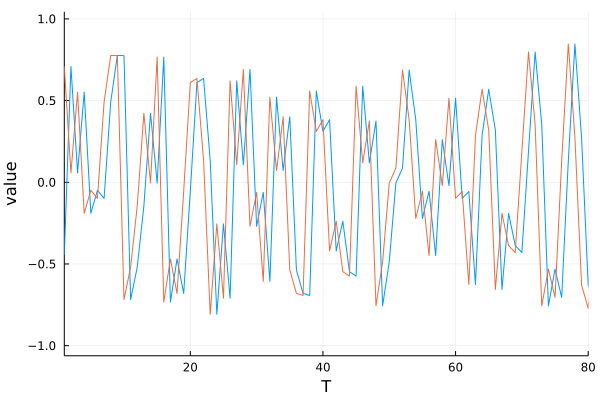

In [45]:
from, to = 1, 80
plot(y_obs, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value", legend=false)

In [46]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = [randn(flow_param_len); [0.1, 1.0]];

In [47]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, vmp_its=5);


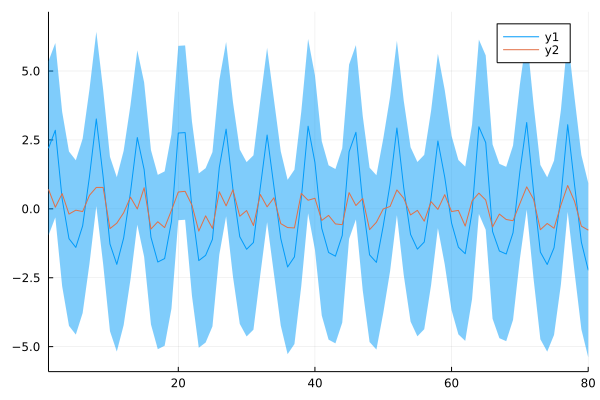

In [48]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

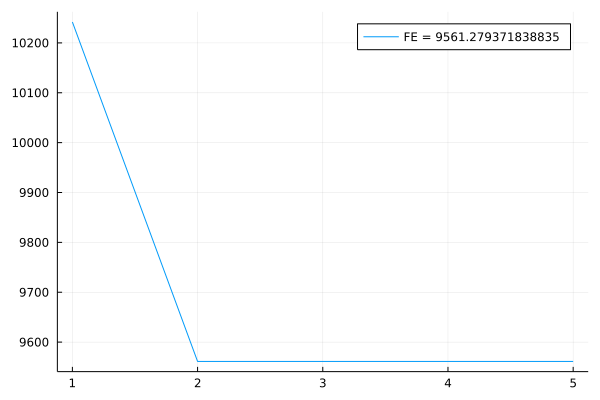

In [49]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [50]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(0.0, 0.1), 
                                                 vmp_its=5)
    return fe[end]
end;

In [51]:
FE(model_params)

9561.279371838835

In [75]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-2.46017, 1.69545, -0.773544, -0.94387, 2.51516, 0.25099, 0.…

In [52]:
import ReactiveMP.fastcholesky
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [53]:
using Optim
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


Iter     Function value   Gradient norm 
     0     9.561279e+03     7.255942e+04
 * time: 0.017835140228271484
    10     2.435683e+03     3.777188e+02
 * time: 107.5573501586914
    20     1.385355e+03     4.128770e+02
 * time: 157.61521196365356
    30     1.147912e+03     5.616873e+02
 * time: 221.66374897956848
    40     8.907469e+02     2.597568e+02
 * time: 274.12997794151306
    50     8.550942e+02     3.373606e+02
 * time: 329.11135697364807
    60     8.122011e+02     4.756726e+02
 * time: 383.181841135025
    70     6.872158e+02     1.349472e+03
 * time: 433.24395394325256
    80     5.947867e+02     4.237577e+02
 * time: 475.21782398223877
    90     5.762217e+02     8.760367e+02
 * time: 527.569354057312
   100     5.091054e+02     2.851359e+02
 * time: 584.512323141098
   110     4.474220e+02     6.084644e+02
 * time: 640.9876461029053
   120     4.074551e+02     3.203297e+02
 * time: 693.6517779827118
   130     3.946630e+02     4.154508e+02
 * time: 749.7136011123657
 

 * Status: success

 * Candidate solution
    Final objective value:     3.051828e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.12e+03 ≰ 1.0e-08

 * Work counters
    Seconds run:   2781  (vs limit Inf)
    Iterations:    186
    f(x) calls:    1316
    ∇f(x) calls:   1316


In [74]:
inf_params = Optim.minimizer(res)


20-element Vector{Float64}:
 -2.460171391729351
  1.6954516483565012
 -0.7735441193382064
 -0.9438702865368012
  2.5151564227005796
  0.2509903821947733
  0.7820095570084022
  2.2625285988491184
  4.145253426611012
  5.423618186160033
 -1.6178326204139815
 -1.820693961086105
  0.2209649554530823
 -4.472303310955015
  2.797880296825803
  4.132178291244484
 -1.623919739920643
  0.5585573576603394
 14.917901478913514
  0.7736953436393407

In [55]:
using JLD
JLD.save("../dump/flow_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [56]:
FE(inf_params)

305.3949178205835

In [57]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=100);


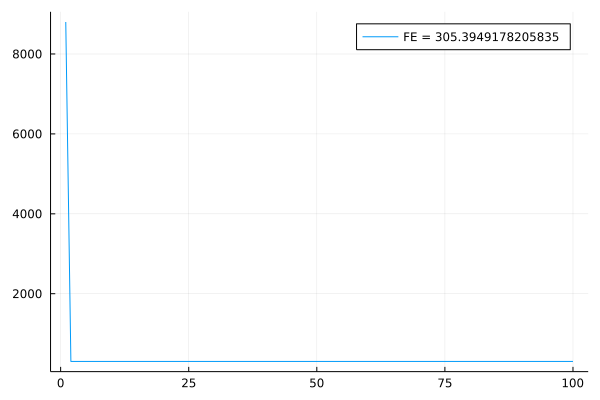

In [58]:
plot(fe_[1:end], label="FE = $(fe_[end])")

In [59]:
from, to = 100, 150

(100, 150)

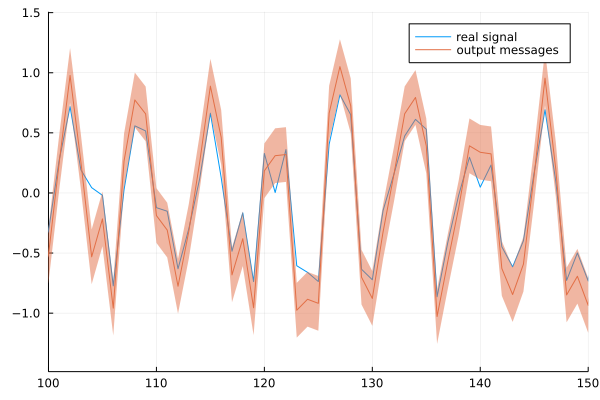

In [76]:
my, vy = mean.(y_out_), cov.(y_out_)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

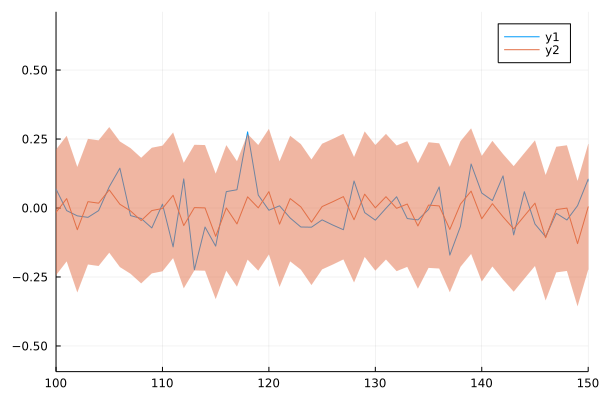

In [77]:
mh, vh = mean.(h_), cov.(h_)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [78]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [79]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_model(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

#     A = shift(dimension) # transition matrix
#     V = transition(w, dimension)

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])
    
#     Ah ~ A*h_0
    h ~ NormalMeanPrecision(h_0, w) where {q = q(h_0, h)q(w)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dimension*3))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_model (generic function with 1 method)

In [80]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_model(model_flow, params, w, h_prior,
                                                                                          observation_prev, control,
                                                                                          options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 1 method)

In [81]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=1);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [82]:
mx, vx = mean.(predictions), cov.(predictions)

([-0.15020476535179447, -5.752612560336766, -9.773750071424079, -0.6796480825064782, 0.8616785972825335, 4.733939484385415, 0.844785673923418, -3.007193787452294, -11.171080800549053, -1.941190809475115  …  -11.139695506047826, -3.5348924675569613, 0.7594847196998549, 4.204122036067617, 1.6363060937113172, -0.6594690237145453, -8.549849204870464, -7.7966052594795645, -0.06496043702543325, 2.403511639868281], [0.5851752142677763, 28.243456981367046, 58.3371109119375, 3.426406429954413, 3.6579915008900064, 15.927145072278472, 5.551272845748608, 8.09474039931647, 44.669665423686126, 7.568136254092335  …  51.30867140567443, 16.450080887685164, 0.8053331504548606, 15.529549256029172, 9.443743216070828, 5.444123267533372, 54.497892379306805, 52.18210735552221, 0.5452509116980913, 12.221568836093367])

In [83]:
test_from, test_to = 150, 200

(150, 200)

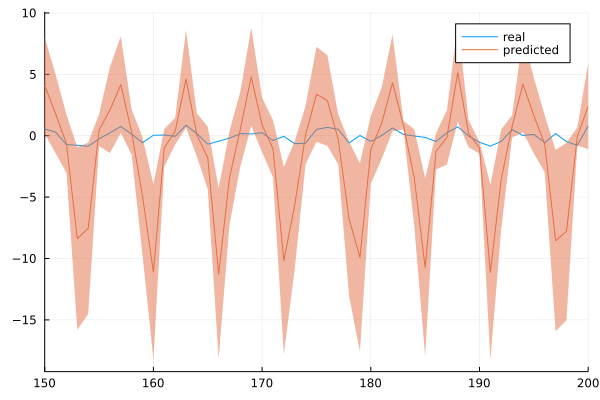

In [84]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")